In [1]:
import sys, os
import numpy as np

sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram.scipy import ScipyPDReactiveODE
from tcg_slb.phasediagram.base import PDReactiveGrid, PDReactiveGridDiagnostics
from tcg_slb.base import *

In [2]:
pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
sys.path.append(os.path.join(os.path.pardir, 'database', 'install', 'Mg2SiO4_all_slb_rx', 'lib', 'python'+pv, 'site-packages'))

import py_Mg2SiO4_all_slb_rx as tcgdb
rxn = tcgdb.Mg2SiO4_all_slb_rx()
rxn.report()

Reaction object: Mg2SiO4_all_slb_rx

Phase 0 Forsterite_slb_ph (fo)
     Endmember 0 Forsterite_slb_em : Mg2SiO4_(fo)
Phase 1 MgWadsleyite_slb_ph (mgwa)
     Endmember 0 MgWadsleyite_slb_em : Mg2SiO4_(mgwa)
Phase 2 MgRingwoodite_slb_ph (mgri)
     Endmember 0 MgRingwoodite_slb_em : Mg2SiO4_(mgri)
Phase 3 MgPerovskite_slb_ph (mgpv)
     Endmember 0 MgPerovskite_slb_em : MgSiO3_(mgpv)
Phase 4 Periclase_slb_ph (pe)
     Endmember 0 Periclase_slb_em : MgO_(pe)
Phase 5 Stishovite_slb_ph (st)
     Endmember 0 Stishovite_slb_em : SiO2_(st)

Reaction 0
     Mg2SiO4_(fo) -> Mg2SiO4_(mgwa)
Reaction 1
     Mg2SiO4_(fo) -> Mg2SiO4_(mgri)
Reaction 2
     Mg2SiO4_(mgwa) -> Mg2SiO4_(mgri)
Reaction 3
     Mg2SiO4_(fo) -> MgSiO3_(mgpv) + MgO_(pe)
Reaction 4
     Mg2SiO4_(fo) -> 2 MgO_(pe) + SiO2_(st)
Reaction 5
     Mg2SiO4_(mgwa) -> MgSiO3_(mgpv) + MgO_(pe)
Reaction 6
     Mg2SiO4_(mgwa) -> 2 MgO_(pe) + SiO2_(st)
Reaction 7
     Mg2SiO4_(mgri) -> MgSiO3_(mgpv) + MgO_(pe)
Reaction 8
     Mg2SiO4_(mgri)

### Setup ODE

In [3]:
ode = ScipyPDReactiveODE(rxn)

#### Temperature, pressure, composition

In [4]:
# initial temperature, pressure and phase volume fraction
Ti = 1150.                # Kelvin
pi = GPa2Bar(23.5)         # bars
Ci0 = [0.8, 0.2]    # unused
i0 =  0                   # initial phase index

#### Initial conditions

In [5]:
mi0 = np.zeros(ode.I)
mi0[i0] = 1.
Cik0 = np.zeros(ode.K)
for i in range(ode.I):
    if ode.Kis[i] == 1:
        Cik0[sum(ode.Kis[:i]):sum(ode.Kis[:i+1])] = 1.
    else:
        Cik0[sum(ode.Kis[:i]):sum(ode.Kis[:i+1])][:] = np.asarray(Ci0)
        
display(mi0, Cik0)

array([1., 0., 0., 0., 0., 0.])

array([1., 1., 1., 1., 1., 1.])

### Solve the system of reactive ODEs at a fixed pressure and temperature

In [23]:
ode.solve(Ti,pi,mi0,Cik0,1000000.0)

In [24]:
ode.stime

0.4774491759999364

In [25]:
ode.final_phases(1.e-2)

(array(['MgRingwoodite_slb_ph'], dtype='<U20'), array(['mgri'], dtype='<U4'))

## Plotting

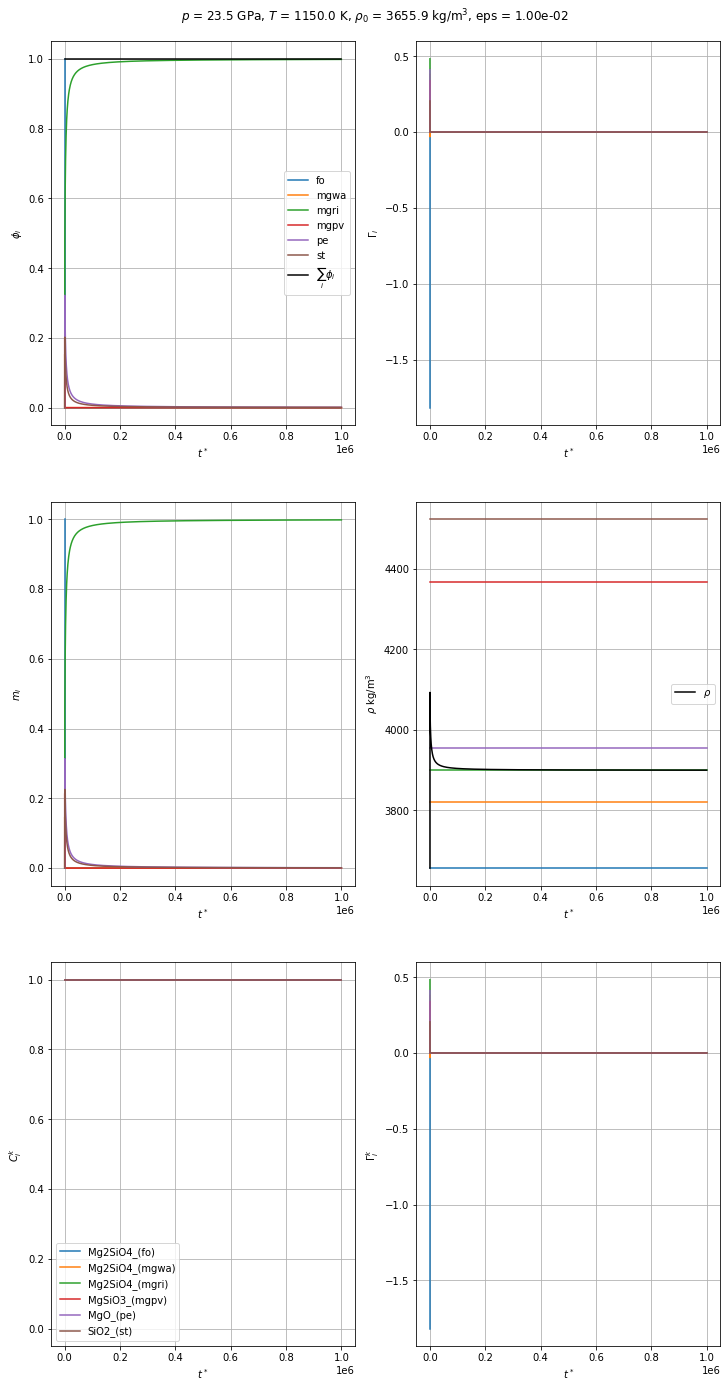

In [26]:
ode.plot()

## Solve for a grid

In [10]:
reload = False

import pickle

filename = os.path.join('output', 'scipy_bdfgrid_mg2sio4_lowp.pickle')

if reload:
    pfile = open(filename, 'rb')
    bdfgrid = pickle.load(pfile)
    pfile.close()
else:
    i0 = 0
    p_n = 60
    p_min = 0.0 + 0.5*29/p_n
    p_max = 29.0 - 0.5*29/p_n
    p_range = np.linspace(p_min, p_max, p_n)
    T_n = 50
    T_min =  800. + 0.5*2000/T_n
    T_max = 2800. - 0.5*2000/T_n
    T_range = np.linspace(T_min, T_max, T_n)
    end = 1e5
    bdfgrid = PDReactiveGrid()
    bdfgrid.solve(rxn, ScipyPDReactiveODE, i0, ['p', 'T'], p_range, T_range, end, **{'Cik0':Cik0})

In [11]:
save = False

if not reload and save:
        pfile = open(filename, 'wb')
        pickle.dump(bdfgrid, pfile)
        pfile.close()

In [12]:
import matplotlib.pyplot as plt

def decorate(pdrgd):
    def new_setup_axes(self,axi):
        img = plt.imread("figures/slb_figure9a.png")
        ip = axi.imshow(img)
        axi.axis('off')
        ax = axi.inset_axes([0.001,0.005,0.998,0.993])
        ax.patch.set_alpha(0.0)
        ax.set_xlim([0.0, 29.0])
        ax.set_ylim([800.0, 2800.0])
        ax.set_ylabel("Temperature (K)")
        ax.set_xlabel("Pressure (GPa)")
        return ax
    
    #replace the display with newdisplay
    pdrgd.setup_axes = new_setup_axes
    
    #return the modified student 
    return pdrgd

bdfdiag = decorate(PDReactiveGridDiagnostics)(rxn,bdfgrid)

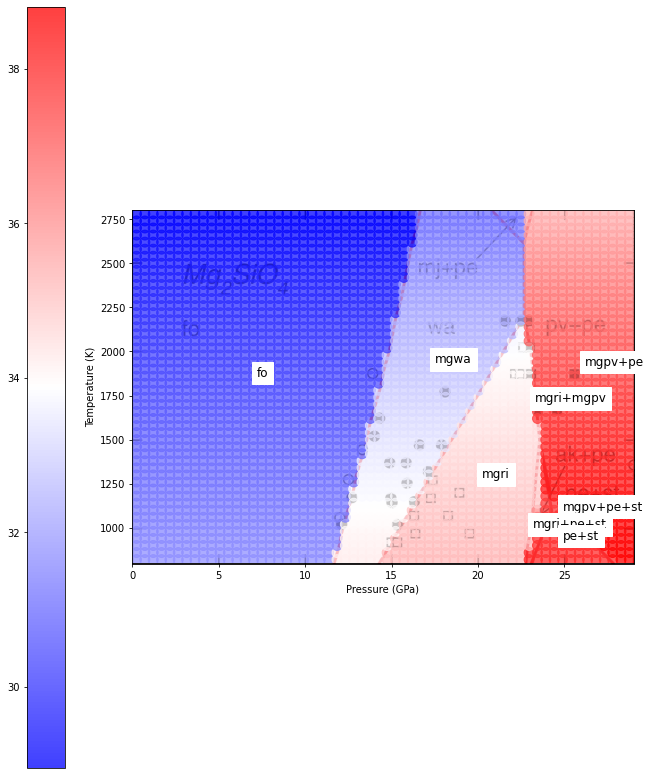

In [13]:
bdfdiag.plot_rho()

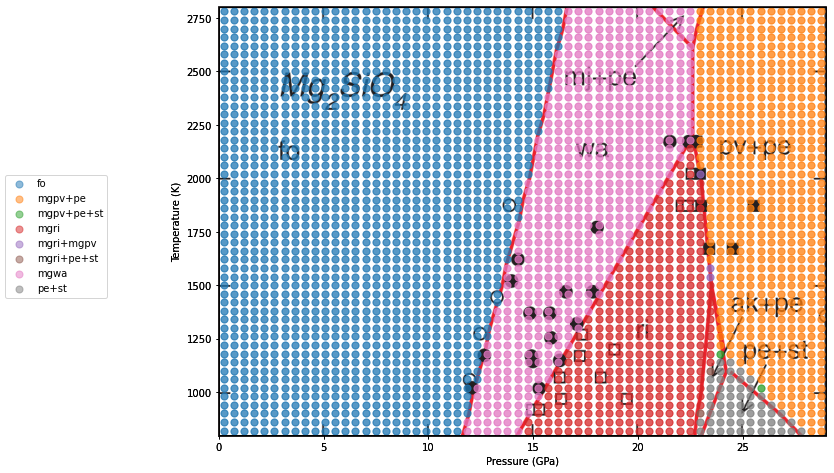

In [14]:
#%matplotlib widget
bdfdiag.plot_phases()

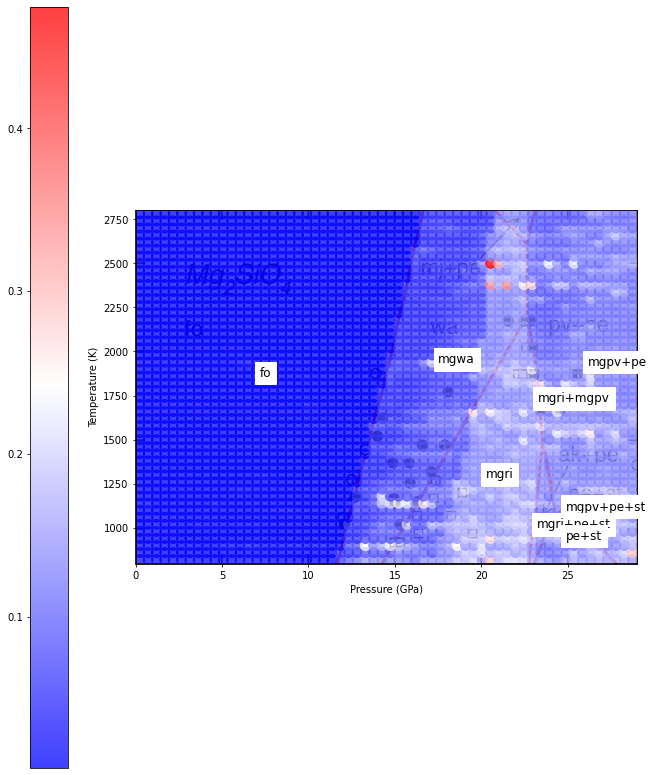

In [15]:
%matplotlib inline
bdfdiag.plot_stime()

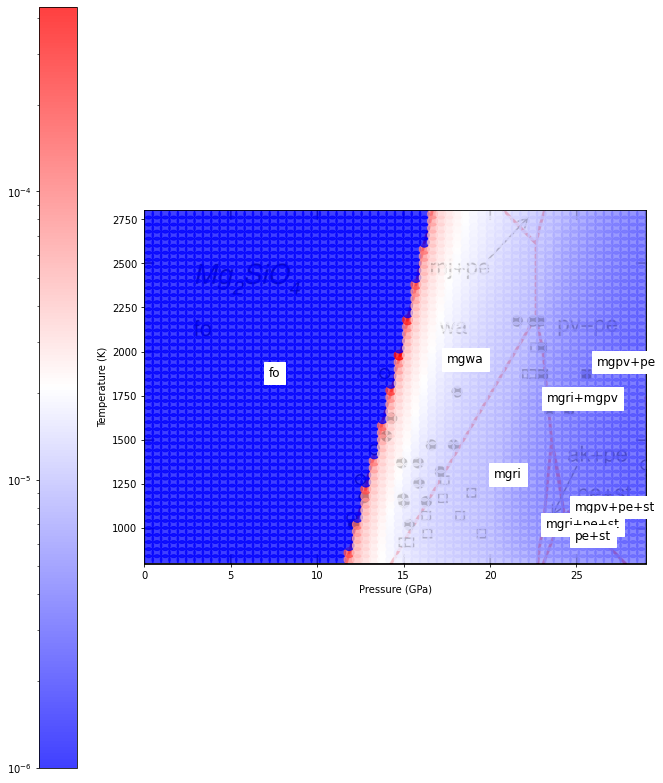

In [16]:
bdfdiag.plot_mindt()

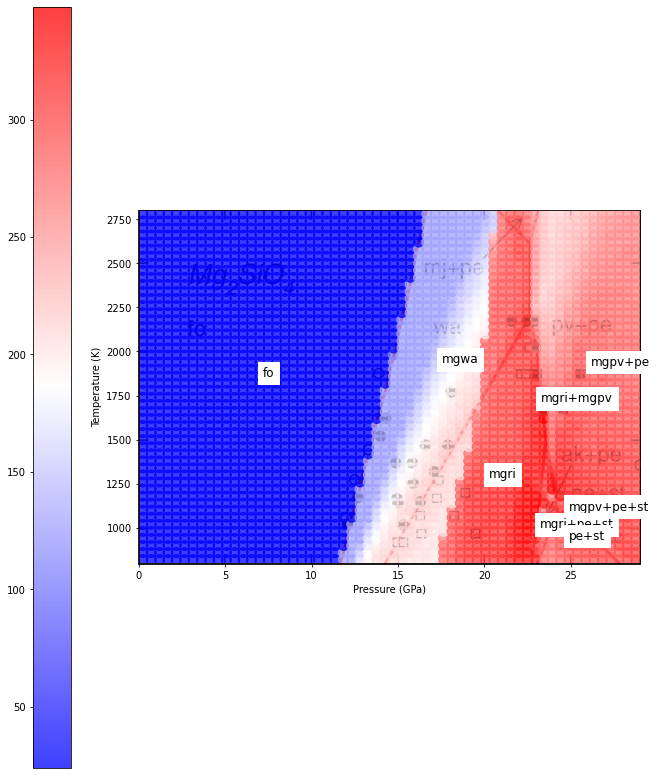

In [17]:
bdfdiag.plot_ndt()